In [2]:
#Import nessesary packages, libraries and global variables

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras

#import sys
#sys.path.append('../modeling')

RSEED = 42
dataset_path = '../data/images/'
dataset_path1 = '../data/train/early_blight'


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_data = train_datagen.flow_from_directory(dataset_path, 
                                               target_size=(224, 224), 
                                               color_mode='rgb',
                                               #batch_size=batch_size, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(dataset_path, 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           #batch_size=batch_size, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 76715 images belonging to 61 classes.
Found 19153 images belonging to 61 classes.


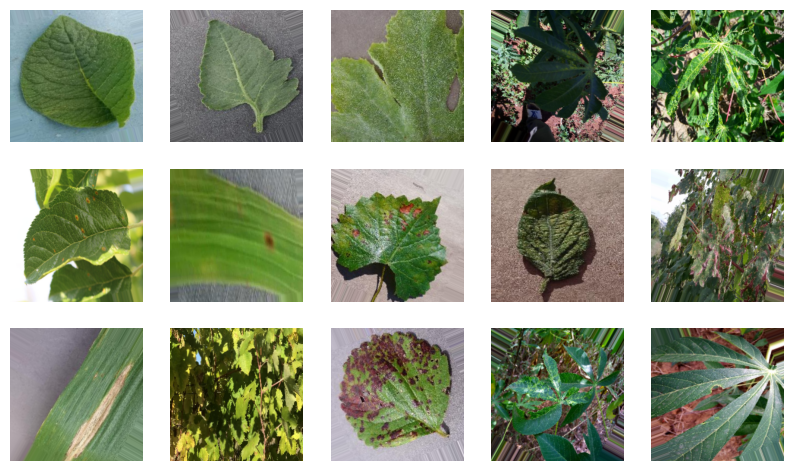

Shape of an augmented image: (224, 224, 3)


In [9]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, _ = train_data.next()

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.show()

# Print the shape of an augmented image
print("Shape of an augmented image:", augmented_images[0].shape)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,  # Shear Intensity
                                    zoom_range=0.2,   # Range for random zoom
                                    horizontal_flip=True,
                                    vertical_flip=True,  # Allowing vertical flips
                                    brightness_range=[0.8, 1.2], 
                                   rotation_range=30,
                                   validation_split=0.2)  # val 20%

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_data1 = train_datagen.flow_from_directory(dataset_path, 
                                               target_size=(224, 224), 
                                               color_mode='rgb',
                                               #batch_size=batch_size, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data1 = val_datagen.flow_from_directory(dataset_path, 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           #batch_size=batch_size, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 76715 images belonging to 61 classes.
Found 19153 images belonging to 61 classes.


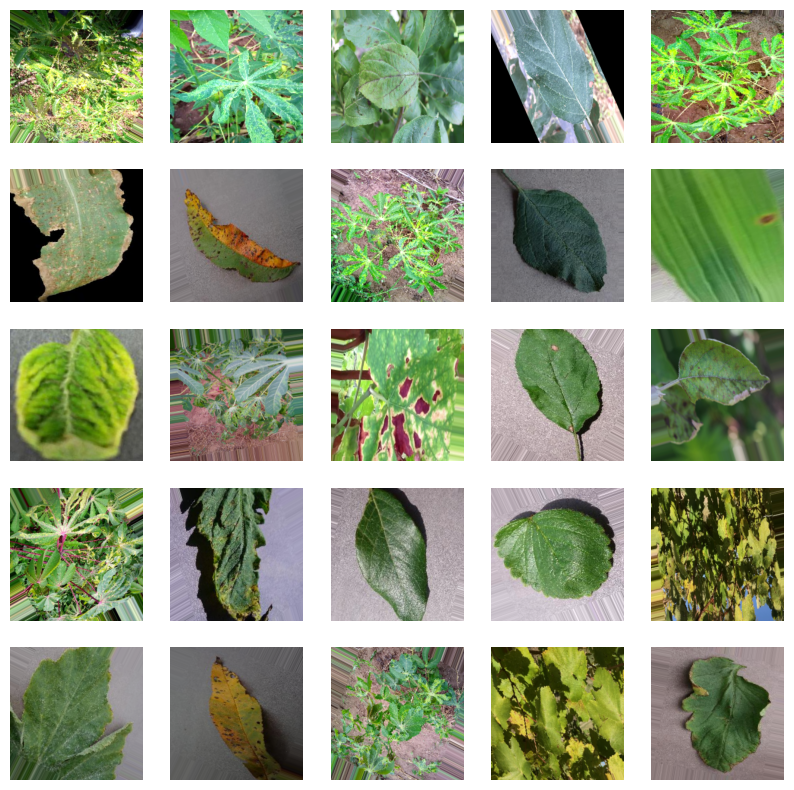

Shape of an augmented image: (224, 224, 3)


In [11]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, _ = train_data1.next()

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.show()

# Print the shape of an augmented image
print("Shape of an augmented image:", augmented_images[0].shape)

# Augmentation and save image to the folder

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import numpy as np

# Define your ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    rotation_range=30
)

# Define the paths
dataset_path2 = '../data/trial_lb/train_leaf_blight/leaf_blight'
output_path2 = '../data/trial_lb/train_leaf_blight_aug/leaf_blight'

# Create the output directory if it doesn't exist
if not os.path.exists(output_path2):
    os.makedirs(output_path2)

# Generate augmented images
for subdir, _, files in os.walk(dataset_path2):
    for file in files:
        img_path = os.path.join(subdir, file)

        # Load the image
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_path2, save_prefix='aug', save_format='jpg'):
            i += 1
            if i > 8:  # Generate three augmented images for each original image
                break


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import numpy as np

# Define your ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    rotation_range=30
)

# Define the paths
dataset_path1 = '../data/trial_lb/train_leaf_blight/healthy'
output_path = '../data/trial_lb/train_leaf_blight_aug/healthy'

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Generate augmented images
for subdir, _, files in os.walk(dataset_path1):
    for file in files:
        img_path = os.path.join(subdir, file)

        # Load the image
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_path, save_prefix='aug', save_format='jpg'):
            i += 1
            if i > 3:  # Generate three augmented images for each original image
                break


# Train and split aug image dataset

In [70]:
data_path_train_lb='../data/trial_lb/train_leaf_blight_aug'

In [71]:
def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [72]:
train_ds_lb, val_ds_lb = load_preprocess_split_train_val(data_path_train_lb)

Found 6600 files belonging to 2 classes.
Using 5280 files for training.
Using 1320 files for validation.


In [24]:
import tensorflow.keras.backend as K
K.clear_session()

In [25]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [26]:
#get overview of the model architecture

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [63]:
from keras import layers
IMG_SIZE = 224


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [64]:
model = build_model(num_classes=2)

In [65]:
epochs = 5
BATCH_SIZE = 32
history = model.fit(train_ds_lb, epochs=epochs, validation_data=val_ds_lb)

Epoch 1/5


165/165 [==============================] - 53s 296ms/step - loss: 0.0577 - accuracy: 0.9850 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 2/5
165/165 [==============================] - 47s 280ms/step - loss: 0.0047 - accuracy: 0.9981 - val_loss: 0.0034 - val_accuracy: 0.9985
Epoch 3/5
165/165 [==============================] - 49s 292ms/step - loss: 0.0483 - accuracy: 0.9939 - val_loss: 8.1749e-06 - val_accuracy: 1.0000
Epoch 4/5
165/165 [==============================] - 48s 285ms/step - loss: 0.0352 - accuracy: 0.9972 - val_loss: 0.0058 - val_accuracy: 0.9985
Epoch 5/5
165/165 [==============================] - 48s 288ms/step - loss: 0.0432 - accuracy: 0.9945 - val_loss: 0.0055 - val_accuracy: 0.9992


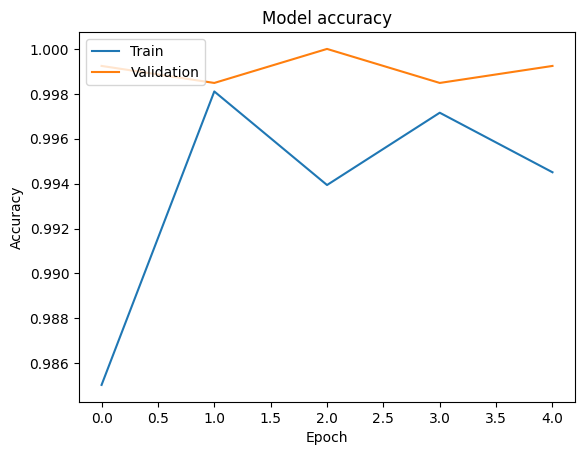

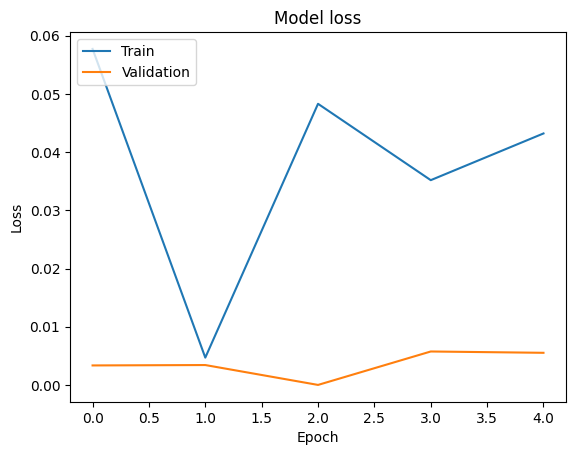

In [66]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [67]:
#next we want to unfreeze 10 layers and retrain 

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model


In [68]:
# Create a new model with unfrozen layers
unfrozen_model2_lb = unfreeze_model_and_clone(model)

epochs = 8
history_lb_lb = unfrozen_model2_lb.fit(train_ds_lb, epochs=epochs, validation_data=val_ds_lb)

Epoch 1/8
165/165 [==============================] - 60s 312ms/step - loss: 0.0154 - accuracy: 0.9981 - val_loss: 0.0099 - val_accuracy: 0.9992
Epoch 2/8
165/165 [==============================] - 49s 289ms/step - loss: 0.0223 - accuracy: 0.9985 - val_loss: 0.0033 - val_accuracy: 0.9992
Epoch 3/8
165/165 [==============================] - 49s 296ms/step - loss: 0.0095 - accuracy: 0.9989 - val_loss: 0.0076 - val_accuracy: 0.9992
Epoch 4/8
165/165 [==============================] - 50s 302ms/step - loss: 0.0066 - accuracy: 0.9989 - val_loss: 0.0055 - val_accuracy: 0.9992
Epoch 5/8
165/165 [==============================] - 54s 320ms/step - loss: 0.0081 - accuracy: 0.9989 - val_loss: 0.0070 - val_accuracy: 0.9992
Epoch 6/8
165/165 [==============================] - 56s 336ms/step - loss: 0.0109 - accuracy: 0.9989 - val_loss: 0.0042 - val_accuracy: 0.9992
Epoch 7/8
165/165 [==============================] - 66s 394ms/step - loss: 0.0095 - accuracy: 0.9992 - val_loss: 0.0060 - val_accuracy:

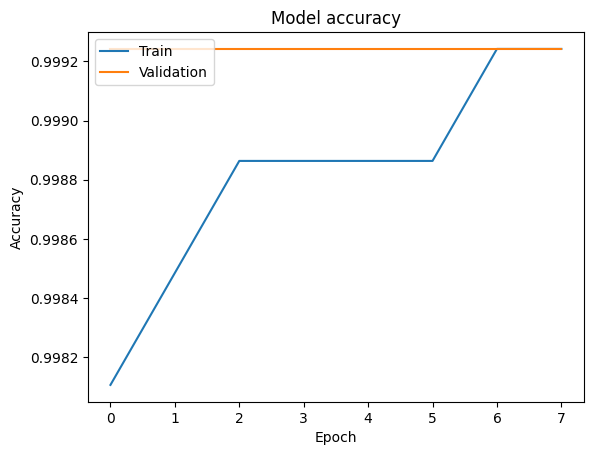

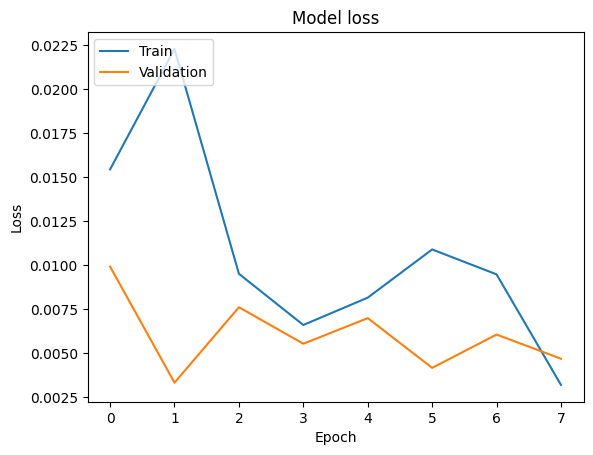

In [69]:
# Plot training & validation accuracy values
plt.plot(history_lb_lb.history['accuracy'])
plt.plot(history_lb_lb.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_lb_lb.history['loss'])
plt.plot(history_lb_lb.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [84]:
model_dir = "../models/"
model_filename = "unfrozen_model2_lb.h5"
unfrozen_model2_lb.save(os.path.join(model_dir, model_filename))


/Users/ankitkumar/Documents/neuefische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 

dataset_test_path = '../data/test_lb'

In [73]:
test_ds = load_test(dataset_test_path)

Found 1384 files belonging to 2 classes.


In [74]:
#check an example 
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [76]:
# Make predictions on the test dataset
predictions = unfrozen_model2_lb.predict(test_ds)

44/44 [==============================] - 17s 305ms/step


#### Plotting the results and getting evaluation metrics

In [77]:
# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred_probabilities = unfrozen_model2_lb.predict(test_ds)

# Step 4: Convert the predicted class probabilities to class labels
y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)



44/44 [==============================] - 11s 252ms/step
Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      1305
 leaf_blight       1.00      1.00      1.00        79

    accuracy                           1.00      1384
   macro avg       1.00      1.00      1.00      1384
weighted avg       1.00      1.00      1.00      1384

Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      1305
 leaf_blight       1.00      1.00      1.00        79

    accuracy                           1.00      1384
   macro avg       1.00      1.00      1.00      1384
weighted avg       1.00      1.00      1.00      1384



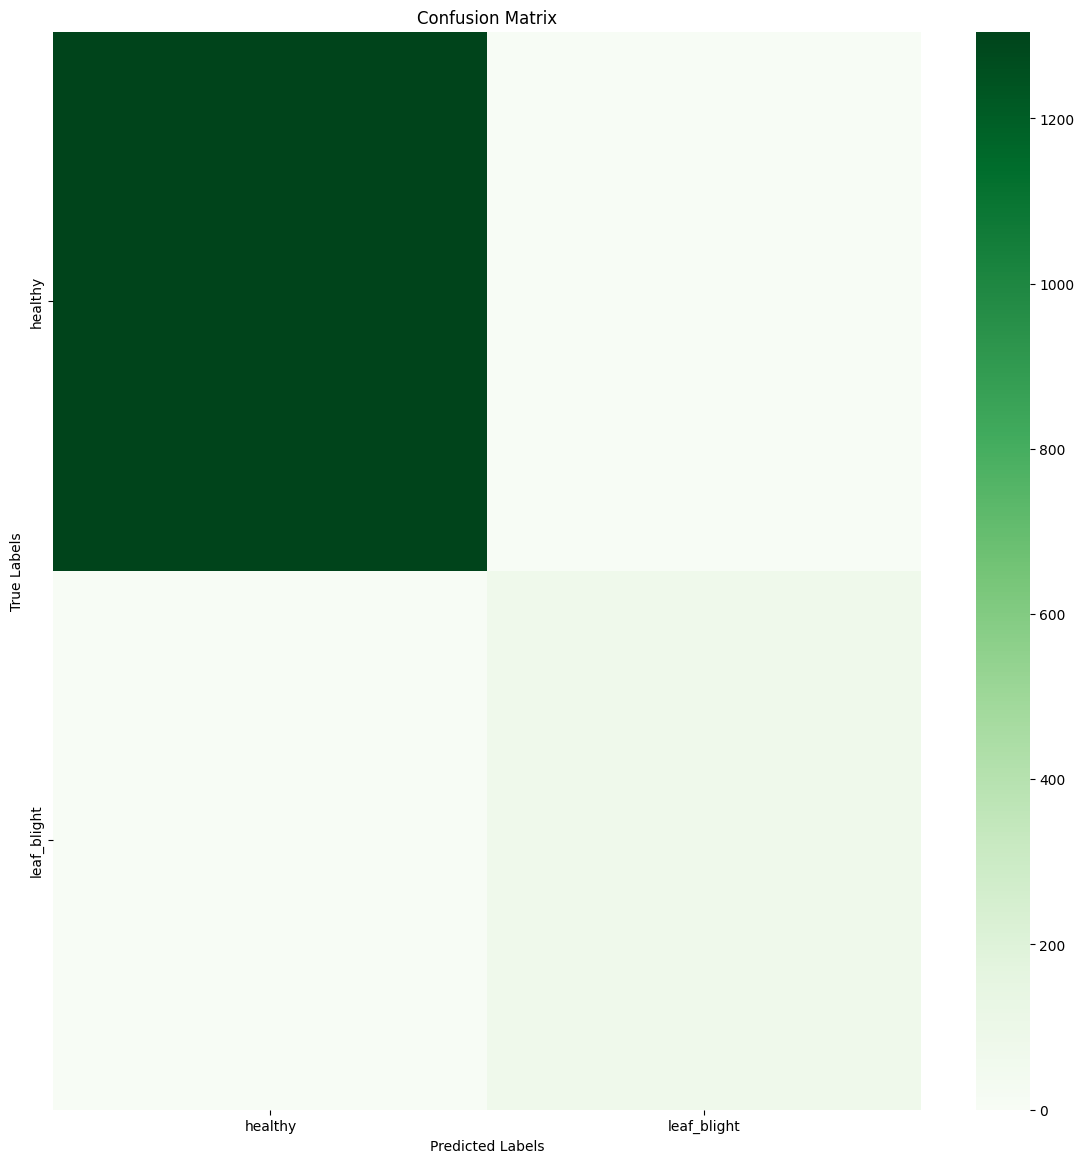

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn heatmap with green color palette
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [76]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom output layers for object detection
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
class_output = Dense(2, activation='softmax', name='class_output')(x)
bbox_output = Dense(2, activation='linear', name='bbox_output')(x)

# Combine inputs and outputs to create the model
model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])

# Define loss functions and metrics
model.compile(optimizer=Adam(lr=1e-4),
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
              metrics={'class_output': 'accuracy'})

# Train the model using annotated dataset
epochs = 5
batch_size = 32
history = model.fit(train_ds_lb, epochs=epochs, batch_size=batch_size, validation_data=val_ds_lb)


Epoch 1/5


2024-02-22 23:50:13.482106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


165/165 [==============================] - 220s 1s/step - loss: 0.2726 - class_output_loss: 0.0340 - bbox_output_loss: 0.2386 - class_output_accuracy: 0.9866 - val_loss: 0.4034 - val_class_output_loss: 0.1762 - val_bbox_output_loss: 0.2272 - val_class_output_accuracy: 0.9409
Epoch 2/5
165/165 [==============================] - 186s 1s/step - loss: 0.2185 - class_output_loss: 0.0639 - bbox_output_loss: 0.1547 - class_output_accuracy: 0.9845 - val_loss: 0.6134 - val_class_output_loss: 0.3920 - val_bbox_output_loss: 0.2214 - val_class_output_accuracy: 0.8932
Epoch 3/5
165/165 [==============================] - 192s 1s/step - loss: 0.1250 - class_output_loss: 0.0274 - bbox_output_loss: 0.0976 - class_output_accuracy: 0.9928 - val_loss: 1.1610 - val_class_output_loss: 1.1549e-06 - val_bbox_output_loss: 1.1610 - val_class_output_accuracy: 1.0000
Epoch 4/5
165/165 [==============================] - 186s 1s/step - loss: 0.1952 - class_output_loss: 0.0394 - bbox_output_loss: 0.1558 - class_outp

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom output layers for object detection
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
class_output = Dense(num_classes=2, activation='softmax', name='class_output')(x)
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)

# Combine inputs and outputs to create the model
model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])

# Define loss functions and metrics
model.compile(optimizer=Adam(lr=1e-4),
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
              metrics={'class_output': 'accuracy'})

# Train the model using annotated dataset
epochs = 5
batch_size = 32
history = model.fit(train_ds_lb, epochs=epochs, batch_size=batch_size, validation_data=val_ds_lb)


In [87]:
model = tf.keras.models.load_model('../models/unfrozen_model2_lb.h5')

1/1 [==============================] - 2s 2s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


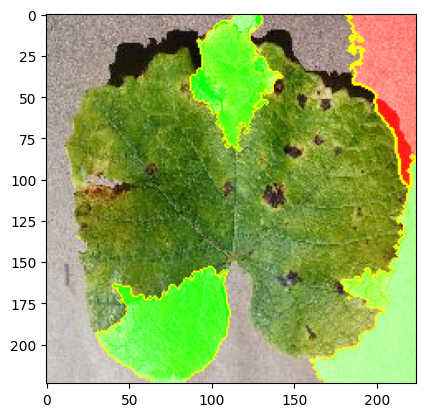

In [59]:
import os
import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
# set IMAGE and MODEL global variables
IMAGE = '../data/test_lb/leaf_blight/0b95527e-6cb8-4d50-95d2-1de6562b22ec___FAM_L.Blight 1702.JPG'
MODEL = keras.models.load_model('../models/unfrozen_model2_lb.h5') 
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out) 
images = transform_img_fn([os.path.join(IMAGE)])
preds = MODEL.predict(images) 
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), MODEL.predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
images = transform_img_fn([os.path.join(IMAGE)])
preds = MODEL.predict(images) 

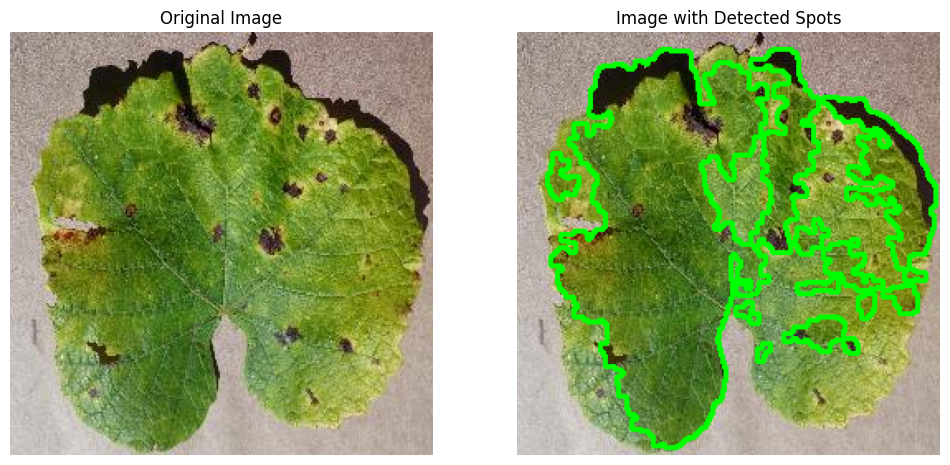

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_spots(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's thresholding to create a binary image
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Perform morphological operations to clean up the binary image
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find contours of the spots
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area to exclude small noise
    min_area = 50
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    # Draw contours on the original image
    spots_image = image.copy()
    cv2.drawContours(spots_image, filtered_contours, -1, (0, 255, 0), 2)
    
    return spots_image

# Assuming 'image' is your preprocessed leaf image
image = cv2.imread('../data/test_lb/leaf_blight/0b95527e-6cb8-4d50-95d2-1de6562b22ec___FAM_L.Blight 1702.JPG')  # Replace 'path_to_your_image.jpg' with the path to your image
detected_spots_image = detect_spots(image)

# Plot the original image and the image with detected spots side by side
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot image with detected spots
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(detected_spots_image, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Spots')
plt.axis('off')

plt.show()


In [7]:
image_path='../data/test_lb/leaf_blight/0b95527e-6cb8-4d50-95d2-1de6562b22ec___FAM_L.Blight 1702.JPG'

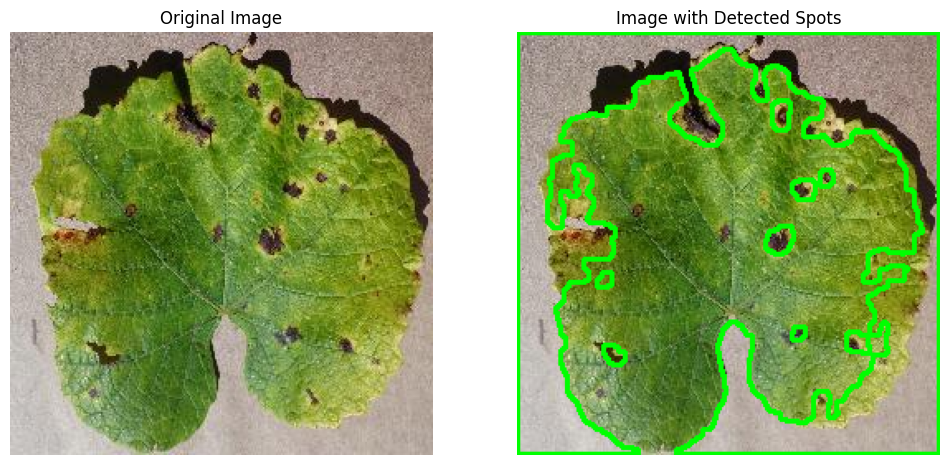

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_spots(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range of green color in HSV
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([90, 255, 255])
    
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Bitwise-AND mask and original image
    green_only = cv2.bitwise_and(image, image, mask=mask)
    
    # Convert the green-only image to grayscale
    gray = cv2.cvtColor(green_only, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's thresholding to create a binary image
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Perform morphological operations to clean up the binary image
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find contours of the spots
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area to exclude small noise
    min_area = 50
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    # Draw contours on the original image
    spots_image = image.copy()
    cv2.drawContours(spots_image, filtered_contours, -1, (0, 255, 0), 2)
    
    return spots_image

# Assuming 'image' is your preprocessed leaf image
image = cv2.imread(image_path)  # Replace 'path_to_your_image.jpg' with the path to your image
detected_spots_image = detect_spots(image)

# Plot the original image and the image with detected spots side by side
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot image with detected spots
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(detected_spots_image, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Spots')
plt.axis('off')

plt.show()


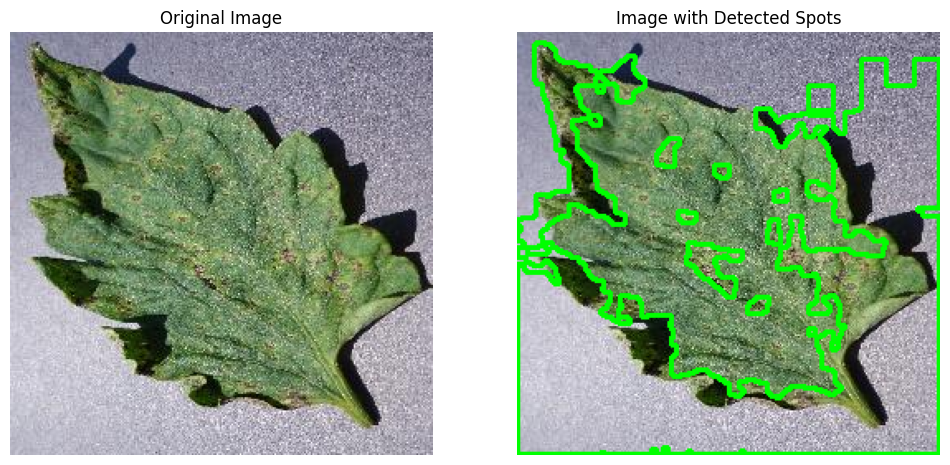

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_spots(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calculate the mean and standard deviation of the green channel
    green_channel = hsv[:,:,0]
    mean_green = np.mean(green_channel)
    std_dev_green = np.std(green_channel)
    
    # Define the lower and upper bounds for green based on mean and standard deviation
    lower_green = np.array([mean_green - std_dev_green, 20, 20])
    upper_green = np.array([mean_green + std_dev_green, 255, 255])
    
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Bitwise-AND mask and original image
    green_only = cv2.bitwise_and(image, image, mask=mask)
    
    # Convert the green-only image to grayscale
    gray = cv2.cvtColor(green_only, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's thresholding to create a binary image
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Perform morphological operations to clean up the binary image
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find contours of the spots
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area to exclude small noise
    min_area = 50
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    # Draw contours on the original image
    spots_image = image.copy()
    cv2.drawContours(spots_image, filtered_contours, -1, (0, 255, 0), 2)
    
    return spots_image

# Assuming 'image' is your preprocessed leaf image
image = cv2.imread('../data/train/septoria_leaf_spot/fef6e580-b1a6-4093-829d-73472fc5c9f9___Matt.S_CG 7545.JPG')  # Replace 'path_to_your_image.jpg' with the path to your image
detected_spots_image = detect_spots(image)

# Plot the original image and the image with detected spots side by side
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot image with detected spots
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(detected_spots_image, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Spots')
plt.axis('off')

plt.show()


In [77]:
import cv2
import numpy as np

# Function to detect spots on leaves using image processing techniques
def detect_spots(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    
    # Perform thresholding to create a binary image
    _, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)
    
    # Perform morphological operations to clean up the image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Find contours of spots
    contours, _ = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on the original image
    spotted_image = image.copy()
    cv2.drawContours(spotted_image, contours, -1, (0, 255, 0), 2)
    
    return spotted_image

# Load the image
image_path = '../data/test_lb/leaf_blight/0b95527e-6cb8-4d50-95d2-1de6562b22ec___FAM_L.Blight 1702.JPG'
image = cv2.imread(image_path)

# Detect spots on the image
result_image = detect_spots(image)

# Display the result
cv2.imshow("Spot Detection Result", result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


: 

In [18]:
file_path = '/Users/ankitkumar/Desktop/pesticides_dataset.xlsx'

In [3]:
import pandas as pd

# Specify the path to your Excel file
excel_file_path = '/Users/ankitkumar/Desktop/pesticides_dataset.xlsx'

# Read the Excel file into a DataFrame, specifying the engine
df = pd.read_excel(excel_file_path)

# Display the DataFrame
print(df)


               disease\n         disease_name\n               disease_type   
0   alternaria_leaf_spot  Alternaria leaf spot              Fungal disease  \
1       bacterial_blight       Bacterial blight        Bacterial disease\n   
2         bacterial_spot         Bacterial spot  Bacterial disease    \n\n   
3         bacterial_wilt         Bacterial wilt    Bacterial disease    \n   
4          black_measles          Black measles        Fungal disease   \n   
5              black_rot              Black rot        Fungal disease   \n   
6                  blast                  Blast        Fungal disease   \n   
7             brown_spot             Brown spot         Various factors \n   
8   brown_streak_disease   Brown streak disease         Virus disease   \n   
9        citrus_greening        Citrus greening    Bacterial disease    \n   
10           common_rust            Common rust        Fungal disease   \n   
11          early_blight           Early blight        Fungal di

In [2]:
df.to_csv('pesticides_dataset.csv', index=False)